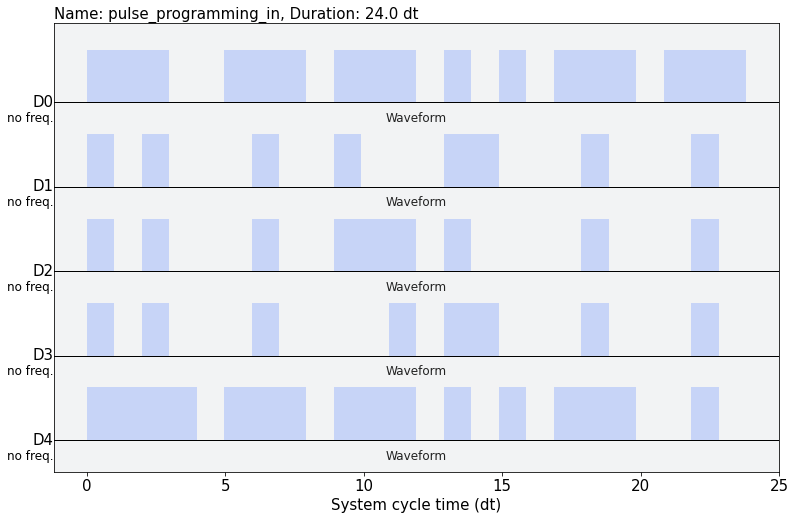

In [1]:
from qiskit import pulse

dc = pulse.DriveChannel
d0, d1, d2, d3, d4 = dc(0), dc(1), dc(2), dc(3), dc(4)

with pulse.build(name='pulse_programming_in') as pulse_prog:
    pulse.play([1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1], d0)
    pulse.play([1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0], d1)
    pulse.play([1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0], d2)
    pulse.play([1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0], d3)
    pulse.play([1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0], d4)

pulse_prog.draw()

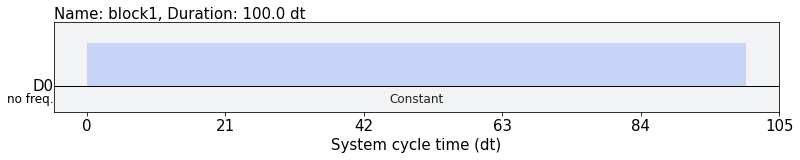

In [2]:
from qiskit import execute, pulse

d0 = pulse.DriveChannel(0)

with pulse.build() as pulse_prog:
    pulse.play(pulse.Constant(100, 1.0), d0)

pulse_prog.draw()

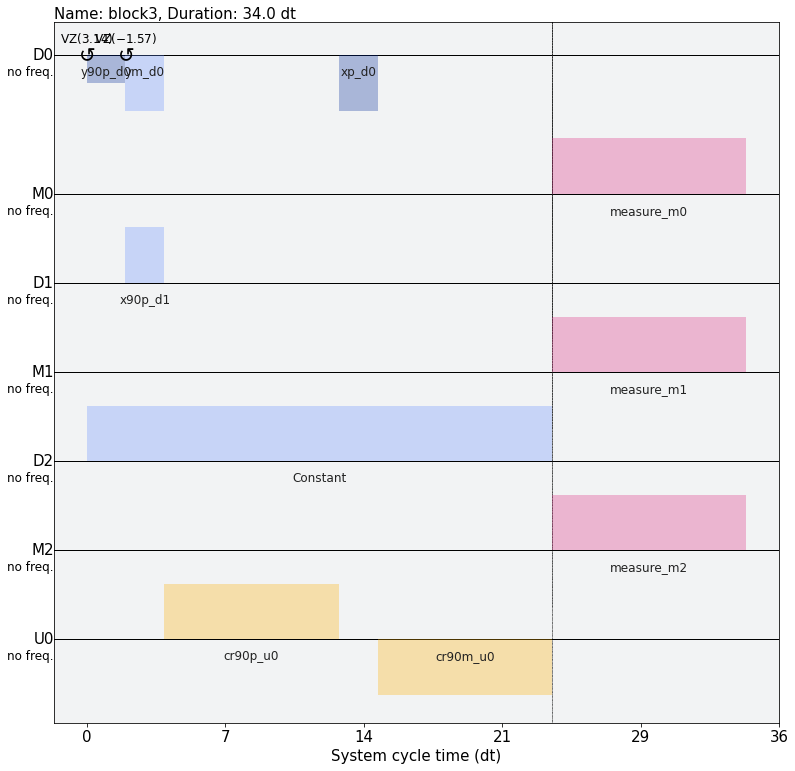

In [3]:
import math

from qiskit import pulse
from qiskit.test.mock import FakeOpenPulse3Q

# TODO: This example should use a real mock backend.
backend = FakeOpenPulse3Q()

d2 = pulse.DriveChannel(2)

with pulse.build(backend) as bell_prep:
    pulse.u2(0, math.pi, 0)
    pulse.cx(0, 1)

with pulse.build(backend) as decoupled_bell_prep_and_measure:
    # We call our bell state preparation schedule constructed above.
    with pulse.align_right():
        pulse.call(bell_prep)
        pulse.play(pulse.Constant(bell_prep.duration, 0.02), d2)
        pulse.barrier(0, 1, 2)
        registers = pulse.measure_all()

decoupled_bell_prep_and_measure.draw()

In [4]:
import math

from qiskit import pulse, QuantumCircuit
from qiskit.pulse import library
from qiskit.test.mock import FakeOpenPulse2Q

backend = FakeOpenPulse2Q()

with pulse.build(backend) as pulse_prog:
    # Create a pulse.
    gaussian_pulse = library.gaussian(10, 1.0, 2)
    # Get the qubit's corresponding drive channel from the backend.
    d0 = pulse.drive_channel(0)
    d1 = pulse.drive_channel(1)
    # Play a pulse at t=0.
    pulse.play(gaussian_pulse, d0)
    # Play another pulse directly after the previous pulse at t=10.
    pulse.play(gaussian_pulse, d0)
    # The default scheduling behavior is to schedule pulses in parallel
    # across channels. For example, the statement below
    # plays the same pulse on a different channel at t=0.
    pulse.play(gaussian_pulse, d1)

    # We also provide pulse scheduling alignment contexts.
    # The default alignment context is align_left.

    # The sequential context schedules pulse instructions sequentially in time.
    # This context starts at t=10 due to earlier pulses above.
    with pulse.align_sequential():
        pulse.play(gaussian_pulse, d0)
        # Play another pulse after at t=20.
        pulse.play(gaussian_pulse, d1)

        # We can also nest contexts as each instruction is
        # contained in its local scheduling context.
        # The output of a child context is a context-schedule
        # with the internal instructions timing fixed relative to
        # one another. This is schedule is then called in the parent context.

        # Context starts at t=30.
        with pulse.align_left():
            # Start at t=30.
            pulse.play(gaussian_pulse, d0)
            # Start at t=30.
            pulse.play(gaussian_pulse, d1)
        # Context ends at t=40.

        # Alignment context where all pulse instructions are
        # aligned to the right, ie., as late as possible.
        with pulse.align_right():
            # Shift the phase of a pulse channel.
            pulse.shift_phase(math.pi, d1)
            # Starts at t=40.
            pulse.delay(100, d0)
            # Ends at t=140.

            # Starts at t=130.
            pulse.play(gaussian_pulse, d1)
            # Ends at t=140.

        # Acquire data for a qubit and store in a memory slot.
        pulse.acquire(100, 0, pulse.MemorySlot(0))

        # We also support a variety of macros for common operations.

        # Measure all qubits.
        pulse.measure_all()

        # Delay on some qubits.
        # This requires knowledge of which channels belong to which qubits.
        # delay for 100 cycles on qubits 0 and 1.
        pulse.delay_qubits(100, 0, 1)

        # Call a quantum circuit. The pulse builder lazily constructs a quantum
        # circuit which is then transpiled and scheduled before inserting into
        # a pulse schedule.
        # NOTE: Quantum register indices correspond to physical qubit indices.
        qc = QuantumCircuit(2, 2)
        qc.cx(0, 1)
        pulse.call(qc)
        # Calling a small set of standard gates and decomposing to pulses is
        # also supported with more natural syntax.
        pulse.u3(0, math.pi, 0, 0)
        pulse.cx(0, 1)


        # It is also be possible to call a preexisting schedule
        tmp_sched = pulse.Schedule()
        tmp_sched += pulse.Play(gaussian_pulse, d0)
        pulse.call(tmp_sched)

        # We also support:

        # frequency instructions
        pulse.set_frequency(5.0e9, d0)

        # phase instructions
        pulse.shift_phase(0.1, d0)

        # offset contexts
        with pulse.phase_offset(math.pi, d0):
            pulse.play(gaussian_pulse, d0)

In [5]:
from qiskit import pulse
from qiskit.test.mock import FakeArmonk

backend = FakeArmonk()

with pulse.build(backend) as drive_sched:
    d0 = pulse.drive_channel(0)
    print(d0)

DriveChannel(0)


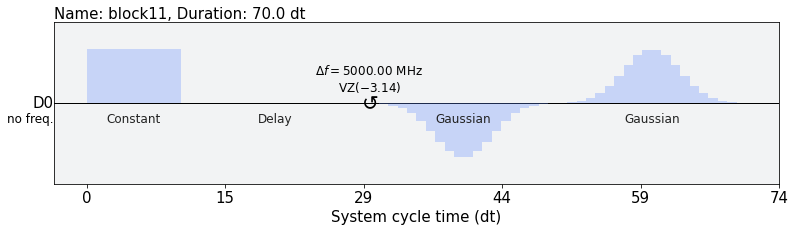

In [6]:
from qiskit import pulse
from qiskit.test.mock import FakeArmonk

backend = FakeArmonk()

with pulse.build(backend) as drive_sched:
    d0 = pulse.drive_channel(0)
    a0 = pulse.acquire_channel(0)

    pulse.play(pulse.library.Constant(10, 1.0), d0)
    pulse.delay(20, d0)
    pulse.shift_phase(3.14/2, d0)
    pulse.set_phase(3.14, d0)
    pulse.shift_frequency(1e7, d0)
    pulse.set_frequency(5e9, d0)

    with pulse.build() as temp_sched:
        pulse.play(pulse.library.Gaussian(20, 1.0, 3.0), d0)
        pulse.play(pulse.library.Gaussian(20, -1.0, 3.0), d0)

    pulse.call(temp_sched)
    pulse.acquire(30, a0, pulse.MemorySlot(0))

drive_sched.draw()

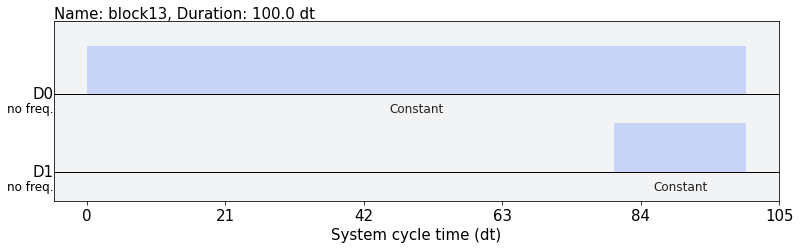

In [7]:
from qiskit import pulse

d0 = pulse.DriveChannel(0)
d1 = pulse.DriveChannel(1)

with pulse.build() as pulse_prog:
    with pulse.align_right():
        # this pulse will start at t=0
        pulse.play(pulse.Constant(100, 1.0), d0)
        # this pulse will start at t=80
        pulse.play(pulse.Constant(20, 1.0), d1)

pulse_prog.draw()

In [8]:
from qiskit import pulse
from qiskit.test.mock import FakeArmonk

backend = FakeArmonk()

with pulse.build(backend) as measure_sched:
    mem_slot = pulse.measure(0)
    print(mem_slot)

MemorySlot(0)


In [9]:
import math

from qiskit import pulse
from qiskit.test.mock import FakeArmonk

backend = FakeArmonk()

with pulse.build(backend) as u3_sched:
    pulse.u3(math.pi, 0, math.pi, 0)

In [10]:
from qiskit import pulse

from qiskit.test.mock import FakeArmonk

backend = FakeArmonk()

with pulse.build(backend) as u3_sched:
    print('Number of qubits in backend: {}'.format(pulse.num_qubits()))

    samples = 160
    print('There are {} samples in {} seconds'.format(
        samples, pulse.samples_to_seconds(160)))

    seconds = 1e-6
    print('There are {} seconds in {} samples.'.format(
        seconds, pulse.seconds_to_samples(1e-6)))

Number of qubits in backend: 1
There are 160 samples in 3.5555555555555554e-08 seconds
There are 1e-06 seconds in 4500 samples.
